<a href="https://colab.research.google.com/github/sharmarahulraj03/NLP_Tasks/blob/main/Assignment_3(B)_DTI5125_Rahul_Raj_Sharma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1 align="center"><b>Data Science Applications</b></H1>
<H3 align="center"><b>Assignment 3</b></H3>
<H5 align="left"><b><u> Introduction:</u></b></H5>
<p align="justify">This assignment should be completed individually using either Python or R. Upon completion, present your result in one submission, including the report, answers generated and plots. Also, submit the source
codes used to generate your results as a separate attachment.
</p>
<H5 align="left"><b><u>Task 2: (50 points)</u></b></H5>
<p align="justify">2) Based on the result of your classifier from assignment 2A, complete the following:
<ol>
<li>Represent the words from the Covid-19 tweets sample data in vector space using the Word2Vec
approach, and compare the accuracy of your assignment 2A model (which used the tf-idf
approach) with the new model (10 points)
</li>
<li>Using the best model from (a), perform a k-fold (k=10) cross-validation in combination with
Gridsearch or Randomsearch to fine-tune the performance of your model by varying its
hyperparameter values (10 points)
</li>
<li>Select another classifier and compare the results of your model based on the following criteria:
Accuracy, Sensitivity and Specificity (10 points)
</li>
<li>Carry out a ROC analysis to compare the performance of your model with the selected classifier.
Plot the ROC graph of the models (10 points)
</li>
<li>After tuning your final model, persist using Pickle or Joblib (10 points)</li>
</ol></p>

**Importing required Libraries.**

In [ ]:
pip install xgboost

In [ ]:
#Import all the important required libraries 
import nltk
import pandas as pd
import numpy as np
import csv
import re
import string
import matplotlib.pyplot as plt
import pickle

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from functools import reduce
from sklearn.datasets import load_iris
from gensim.models import word2vec
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve,auc,plot_roc_curve
from sklearn.model_selection import StratifiedKFold

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Import Train and Test data
covid_test_data = pd.read_csv("Covid_test_data.csv")
covid_train_data = pd.read_csv("Covid_train_data.csv" , encoding='latin-1')

In [ ]:
#Display first 10 rows of test data
covid_test_data.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
5,6,44958,Los Angeles,03-03-2020,Do you remember the last time you paid $2.99 a...,Neutral
6,7,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanit...,Positive
7,8,44960,"Geneva, Switzerland",03-03-2020,"@DrTedros ""We cant stop #COVID19 without prot...",Neutral
8,9,44961,NaN,04-03-2020,HI TWITTER! I am a pharmacist. I sell hand san...,Extremely Negative
9,10,44962,"Dublin, Ireland",04-03-2020,Anyone been in a supermarket over the last few...,Extremely Positive


In [ ]:
#Display first 10 rows of train data 
covid_train_data.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative


In [ ]:
#Display data before Preprocessing 
#Display the first five rows of train data to get an idea 
display(covid_train_data.head())
#Print the summary statistics for train data
print(covid_train_data.describe())
#information print about train data
print(covid_train_data.info())

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


           UserName    ScreenName
count  41157.000000  41157.000000
mean   24377.000000  69329.000000
std    11881.146851  11881.146851
min     3799.000000  48751.000000
25%    14088.000000  59040.000000
50%    24377.000000  69329.000000
75%    34666.000000  79618.000000
max    44955.000000  89907.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
None


In [ ]:
#Removing first 2 unnecessary columns
covid_train_data.drop(columns=["UserName", "ScreenName"], axis=1, inplace=True)
#Removing duplicated rows
covid_train_data.drop_duplicates(inplace=True)
#Changing datatype
covid_train_data["TweetAt"] = pd.to_datetime(covid_train_data["TweetAt"])
# Print the information of Train data
print(covid_train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 0 to 41156
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Location       32567 non-null  object        
 1   TweetAt        41157 non-null  datetime64[ns]
 2   OriginalTweet  41157 non-null  object        
 3   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.6+ MB
None


In [ ]:
#Function for Preprocessing the Train data
def process_tweets(tweet):
    
    # Remove links
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    # Remove mentions and hashtag
    tweet = re.sub(r'\@\w+|\#','', tweet)
    
    # Tokenize the words
    tokenized = word_tokenize(tweet)

    # Remove the stop words
    tokenized = [token for token in tokenized if token not in stopwords.words("english")] 

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokenized = [lemmatizer.lemmatize(token, pos='a') for token in tokenized]

    # Remove non-alphabetic characters and keep the words contains three or more letters
    tokenized = [token for token in tokenized if token.isalpha() and len(token)>2]
    
    return tokenized
    
# Call the function and store the result into a new column
covid_train_data["Processed"] = covid_train_data["OriginalTweet"].str.lower().apply(process_tweets)

# Print the first ten rows of Processed
covid_train_data.head(10)

,Location,TweetAt,OriginalTweet,Sentiment,Processed
0,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,[]
1,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,"[advice, talk, neighbours, family, exchange, p..."
2,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,"[coronavirus, australia, woolworths, give, eld..."
3,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,"[food, stock, one, empty, please, panic, enoug..."
4,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"[ready, supermarket, outbreak, paranoid, food,..."
5,"ÃT: 36.319708,-82.363649",2020-03-16,As news of the regionÂs first confirmed COVID...,Positive,"[news, first, confirmed, case, came, sullivan,..."
6,"35.926541,-78.753267",2020-03-16,Cashier at grocery store was sharing his insig...,Positive,"[cashier, grocery, store, sharing, insights, p..."
7,Austria,2020-03-16,Was at the supermarket today. Didn't buy toile...,Neutral,"[supermarket, today, buy, toilet, paper, rebel..."
8,"Atlanta, GA USA",2020-03-16,Due to COVID-19 our retail store and classroom...,Positive,"[due, retail, store, classroom, atlanta, open,..."
9,"BHAVNAGAR,GUJRAT",2020-03-16,"For corona prevention,we should stop to buy th...",Negative,"[corona, prevention, stop, buy, things, cash, ..."


In [ ]:
# Get the tweet lengths for train data
covid_train_data["Length"] = covid_train_data["OriginalTweet"].str.len()
# Get the number of words in tweets train data
covid_train_data["Words"] = covid_train_data["OriginalTweet"].str.split().str.len()
# Display the new columns of train data
display(covid_train_data[["Length", "Words"]])

,Length,Words
0,111,8
1,237,38
2,131,14
3,306,42
4,310,40
...,...,...
41152,102,12
41153,138,23
41154,136,18
41155,111,18


In [ ]:
# Fill the missing values with unknown tag in train data
covid_train_data["Location"].fillna("unknown", inplace=True)

In [ ]:
#function for preprocessing Test data in order to use further in calculating accuracy
def process_tweets(tweet):
    
    # Remove links
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    # Remove mentions and hashtag
    tweet = re.sub(r'\@\w+|\#','', tweet)
    
    # Tokenize the words
    tokenized = word_tokenize(tweet)

    # Remove the stop words
    tokenized = [token for token in tokenized if token not in stopwords.words("english")] 

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokenized = [lemmatizer.lemmatize(token, pos='a') for token in tokenized]

    # Remove non-alphabetic characters and keep the words contains three or more letters
    tokenized = [token for token in tokenized if token.isalpha() and len(token)>2]
    
    return tokenized
    
# Call the function and store the result into a new column
covid_test_data["Processed"] = covid_test_data["OriginalTweet"].str.lower().apply(process_tweets)

# Print the first ten rows of Processed
covid_test_data.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Processed
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,"[trending, new, yorkers, encounter, empty, sup..."
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,"[could, find, hand, sanitizer, fred, meyer, tu..."
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,"[find, protect, loved, ones, coronavirus]"
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,"[panic, buying, hits, newyork, city, anxious, ..."
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,"[toiletpaper, dunnypaper, coronavirus, coronav..."
5,6,44958,Los Angeles,03-03-2020,Do you remember the last time you paid $2.99 a...,Neutral,"[remember, last, time, paid, gallon, regular, ..."
6,7,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanit...,Positive,"[voting, age, coronavirus, hand, sanitizer, su..."
7,8,44960,"Geneva, Switzerland",03-03-2020,"@DrTedros ""We cant stop #COVID19 without prot...",Neutral,"[stop, without, protecting, healthworkers, pri..."
8,9,44961,NaN,04-03-2020,HI TWITTER! I am a pharmacist. I sell hand san...,Extremely Negative,"[twitter, pharmacist, sell, hand, sanitizer, l..."
9,10,44962,"Dublin, Ireland",04-03-2020,Anyone been in a supermarket over the last few...,Extremely Positive,"[anyone, supermarket, last, days, went, normal..."


In [ ]:
# Get the tweet lengths of test data
covid_test_data["Length"] = covid_test_data["OriginalTweet"].str.len()
# Get the number of words in tweets of test data
covid_test_data["Words"] = covid_test_data["OriginalTweet"].str.split().str.len()
# Display the new columns of test data
display(covid_test_data[["Length", "Words"]])

,Length,Words
0,228,23
1,193,30
2,73,13
3,318,37
4,252,26
...,...,...
3793,127,18
3794,213,34
3795,185,26
3796,174,29


**TF-IDF for train data (Part of Assignment 2)**

In [ ]:
# Initialize a Tf-idf Vectorizer
vectorizer = TfidfVectorizer(max_features=100)
# Fit and transform the vectorizer
tfidf_matrix = vectorizer.fit_transform([' '.join(l) for l in covid_train_data["Processed"]])
# Let's see what we have
display(tfidf_matrix)
# Create a DataFrame for tf-idf vectors and display the first rows
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns= vectorizer.get_feature_names())
display(tfidf_df)

<41157x100 sparse matrix of type '<class 'numpy.float64'>'
	with 186001 stored elements in Compressed Sparse Row format>

,also,amid,amp,back,business,buy,buying,consumer,coronavirus,could,covid,crisis,customers,day,delivery,demand,due,employees,essential,even,every,everyone,first,food,get,going,good,government,grocery,hand,health,help,high,home,impact,items,keep,know,like,local,...,prices,products,retail,right,safe,sanitizer,see,shelves,shop,shopping,social,socialdistancing,spread,staff,stay,still,stock,stop,store,stores,supermarket,supplies,supply,take,thank,think,time,today,toilet,toiletpaper,use,via,virus,way,week,work,workers,working,world,would
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.497447,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.702164,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.617436,0.0,0.0,0.0,0.0,0.0,0.000000,0.243451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.453185,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.115334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287786,0.0,0.358077,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.291483,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.551151,0.0,0.250835,0.0,0.0,0.0,0.000000,0.000000,0.0,0.282739,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.197031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.305863,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.428518,0.0,0.0,0.0,0.292708,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41152,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.549792,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.503874,0.0,0.0,0.0,0.344182,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
41153,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.558534,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.829481,0.0,0.0,0.0,0.0,0.0,0.0
41154,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
# Encode the labels for train data
le = LabelEncoder()
covid_train_data["Label_enc"] = le.fit_transform(covid_train_data["Sentiment"])
# Display the encoded labels of train data
display(covid_train_data[["Label_enc"]].head())

,Label_enc
0,3
1,4
2,4
3,4
4,0


In [ ]:
# Encode the labels for test data 
le = LabelEncoder()
covid_test_data["Label_enc"] = le.fit_transform(covid_test_data["Sentiment"])
# Display the encoded labels of test data
display(covid_test_data[["Label_enc"]].head())

,Label_enc
0,0
1,4
2,1
3,2
4,3


In [ ]:
# Select the features and the target and split train and test
X_train = covid_train_data['Processed']
Y_train = covid_train_data["Label_enc"]
X_test = covid_test_data['Processed']
Y_test = covid_test_data["Label_enc"]

In [ ]:
# Create the tf-idf vectorizer
model_vectorizer = TfidfVectorizer()
# First fit the vectorizer with our training set
tfidf_train = vectorizer.fit_transform([' '.join(l) for l in X_train])
# Now we can fit our test data with the same vectorizer
tfidf_test = vectorizer.transform([' '.join(l) for l in X_test])

In [ ]:
def generate_rf(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(n_estimators=5, min_samples_leaf=3)
    rf.fit(X_train, y_train)
    print ("rf score ", rf.score(X_test, y_test))
    return rf

def combine_rfs(rf_a, rf_b):
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a


# in the line below, we create 10 random forest classifier models
rfs_tfidf = [generate_rf(tfidf_train, Y_train, tfidf_test, Y_test)]
# in this step below, we combine the list of random forest models into one giant model
rf_tfidf_combined = reduce(combine_rfs, rfs_tfidf)
# the combined model scores better than most of the component models
print ("rf combined score", rf_tfidf_combined.score(tfidf_test, Y_test))
# Print the accuracy score
best_accuracy = cross_val_score(rf_tfidf_combined, tfidf_test, Y_test, cv=10, scoring='accuracy').max()
print("Accuracy:",best_accuracy)

rf score  0.35624012638230645
rf combined score 0.35624012638230645
Accuracy: 0.3562005277044855


**1. Represent the words from the Covid-19 tweets sample data in vector space using the Word2Vec approach, and compare the accuracy of your assignment 2A model (which used the tf-idf approach) with the new model (10 points)**

In [ ]:
# Word Embeddings
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in  X_train.str.join(' ')]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality, i.e., number of dimension we wish to represent the word 
window_context = 10  # Context window size                                                                                    
min_word_count = 1   # Minimum word count, i.e., words > this are going to be included in the model                        
sample = 1e-3        # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample)

In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)


w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
w2v_train = pd.DataFrame(w2v_feature_array)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [ ]:
# Word Embeddings
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in  X_test.str.join(' ')]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality, i.e., number of dimension we wish to represent the word 
window_context = 10  # Context window size                                                                                    
min_word_count = 1   # Minimum word count, i.e., words > this are going to be included in the model                        
sample = 1e-3        # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample)

In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)


w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
w2v_test = pd.DataFrame(w2v_feature_array)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [ ]:
def generate_rf(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(n_estimators=5, min_samples_leaf=3)
    rf.fit(X_train, y_train)
    print ("rf score ", rf.score(X_test, y_test))
    return rf

def combine_rfs(rf_a, rf_b):
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a


# in the line below, we create 10 random forest classifier models
rfs_w2v = [generate_rf(w2v_train, Y_train, w2v_test, Y_test)]
# in this step below, we combine the list of random forest models into one giant model
rf_w2v_combined = reduce(combine_rfs, rfs_w2v)
# the combined model scores better than most of the component models
print ("rf combined score", rf_w2v_combined.score(w2v_test, Y_test))
# Print the accuracy score
best_accuracy = cross_val_score(rf_w2v_combined, w2v_test, Y_test, cv=10, scoring='accuracy').max()
print("Accuracy:",best_accuracy)

rf score  0.27593470247498686
rf combined score 0.27593470247498686
Accuracy: 0.3034300791556728


**2. Using the best model from (a), perform a k-fold (k=10) cross-validation in combination with Gridsearch or Randomsearch to fine-tune the performance of your model by varying its hyperparameter values (10 points)**

As we clearly see that the accuracy for TF-IDF using random forest classifier is better than the accuracy for Word2Vec using random forest classifer.

In [ ]:
def performance(ypred, yactl):
    print(f'F1-score  : {f1_score(yactl, ypred, average="macro")}')
    print(f'Accuracy  : {accuracy_score(yactl, ypred)}')
    print(f'Precision : {precision_score(yactl, ypred, average="macro")}')
    print(f'Recall    : {recall_score(yactl, ypred, average="macro")}')

In [ ]:
rfc = RandomForestClassifier(n_jobs=-1)
n_estimators = [150,200,300]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10,20,40]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [150, 200, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 40, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
rf_random = RandomizedSearchCV(estimator=rfc, param_distributions=random_grid, cv=10, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(tfidf_df, Y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.2min
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 27.3min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

In [ ]:
#Finding best parameters 
rf_random.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 150}

In [ ]:
#Initializing best parameters 
rfc = RandomForestClassifier(n_estimators=150,
                             min_samples_split= 2,
                             min_samples_leaf= 4,
                             max_features= 'auto',
                             max_depth= None,
                             bootstrap= True)

In [ ]:
rfc.fit(tfidf_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
pred = rfc.predict(tfidf_test)

In [ ]:
pred_prob = rfc.predict_proba(tfidf_test)

In [ ]:
performance(pred, Y_test)

F1-score  : 0.37581781774847356
Accuracy  : 0.37783043707214325
Precision : 0.4094355001382114
Recall    : 0.37043085589238967


In [ ]:
# Print the Confusion Matrix
cm = confusion_matrix(Y_test, pred)
print("Confusion Matrix\n")
print(cm)
# Print the Classification Report
cr = classification_report(Y_test, pred)
print("\n\nClassification Report\n")
print(cr)

Confusion Matrix

[[157  20 202  74 139]
 [ 25 184  89  71 230]
 [101  44 378 193 325]
 [ 14   9 135 287 174]
 [ 35 104 205 174 429]]


Classification Report

              precision    recall  f1-score   support

           0       0.47      0.27      0.34       592
           1       0.51      0.31      0.38       599
           2       0.37      0.36      0.37      1041
           3       0.36      0.46      0.40       619
           4       0.33      0.45      0.38       947

    accuracy                           0.38      3798
   macro avg       0.41      0.37      0.38      3798
weighted avg       0.40      0.38      0.38      3798



In [ ]:
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))

    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 

In [ ]:
confusion_metrics(cm)

True Positives: 184
True Negatives: 157
False Positives: 20
False Negatives: 25
Sensitivity: 0.88
Specificity: 0.89


**3. Select another classifier and compare the results of your model based on the following criteria: Accuracy, Sensitivity and Specificity (10 points)**

In [ ]:
silent = False,
max_depth= 6, 10, 15, 20,
learning_rate = 0.001, 0.01, 0.1, 0.2, 0,3,
subsample= 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
colsample_bytree= 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
colsample_bylevel= 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
min_child_weight= 0.5, 1.0, 3.0, 5.0, 7.0, 10.0,
gamma = 0, 0.25, 0.5, 1.0,
reg_lambda= 0.1, 1.0, 5.0, 10.0, 50.0, 100.0,
n_estimators = [100]

In [ ]:
model = XGBClassifier()
param_grid = dict(
        max_depth = max_depth,
        learning_rate = learning_rate,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        colsample_bylevel = colsample_bylevel,
        min_child_weight = min_child_weight,
        gamma = gamma,
        reg_lambda = reg_lambda,
         n_estimators = n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

In [ ]:
xgb_random = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=kfold, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
xgb_random.fit(tfidf_df, Y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 52.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 124.3min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=7, shuffle=True),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='bina...
                                                             0.8, 0.9, 1.0),
                                        'gamma': (0, 0.25, 0.5, 1.0),
                                        'learning_rate': (0.001, 0.01, 0.1, 0.2,
                  

In [ ]:
xgb_random.best_params_

{'colsample_bylevel': 0.4,
 'colsample_bytree': 1.0,
 'gamma': 0.5,
 'learning_rate': 0.1,
 'max_depth': 20,
 'min_child_weight': 7.0,
 'n_estimators': 100,
 'reg_lambda': 100.0,
 'subsample': 0.8}

In [ ]:
silent = False,
max_depth= 20
learning_rate = 0.1
subsample= 0.8
colsample_bytree= 1.0
colsample_bylevel= 0.4
min_child_weight= 7.0
gamma = 0.5
reg_lambda= 100.0
n_estimators = [100]

In [ ]:
model = XGBClassifier()
param_grid = dict(
        max_depth = max_depth,
        learning_rate = learning_rate,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        colsample_bylevel = colsample_bylevel,
        min_child_weight = min_child_weight,
        gamma = gamma,
        reg_lambda = reg_lambda,
         n_estimators = n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

In [ ]:
model.fit(tfidf_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
pred = model.predict(tfidf_test)

In [ ]:
pred_prob = model.predict_proba(tfidf_test)

In [ ]:
performance(pred, Y_test)

F1-score  : 0.3351578771521648
Accuracy  : 0.3499210110584518
Precision : 0.4031983584914157
Recall    : 0.3349124104298045


In [ ]:
# Print the Confusion Matrix
cm = confusion_matrix(Y_test, pred)
print("Confusion Matrix\n")
print(cm)
# Print the Classification Report
cr = classification_report(Y_test, pred)
print("\n\nClassification Report\n")
print(cr)

Confusion Matrix

[[156  12 131  59 234]
 [ 21 138  58  47 335]
 [122  29 230 149 511]
 [  8   7  71 196 337]
 [ 35  73 116 114 609]]


Classification Report

              precision    recall  f1-score   support

           0       0.46      0.26      0.33       592
           1       0.53      0.23      0.32       599
           2       0.38      0.22      0.28      1041
           3       0.35      0.32      0.33       619
           4       0.30      0.64      0.41       947

    accuracy                           0.35      3798
   macro avg       0.40      0.33      0.34      3798
weighted avg       0.39      0.35      0.34      3798



In [ ]:
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))

    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 

In [ ]:
confusion_metrics(cm)

True Positives: 138
True Negatives: 156
False Positives: 12
False Negatives: 21
Sensitivity: 0.87
Specificity: 0.93


**4. Carry out a ROC analysis to compare the performance of your model with the selected classifier. Plot the ROC graph of the models (10 points)**

In [ ]:
rfc_pred_prob = rfc.predict_proba(tfidf_test)
model_pred_prob2 = model.predict_proba(tfidf_test)

In [ ]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(Y_test, rfc_pred_prob[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(Y_test, model_pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

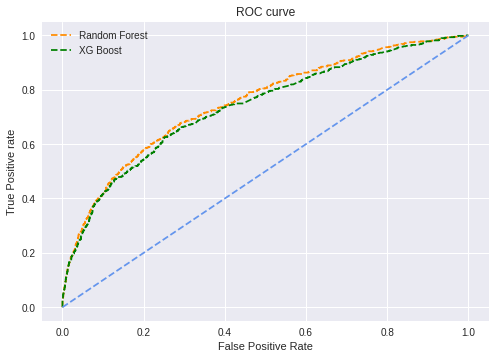

In [ ]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='darkorange', label='Random Forest')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='XG Boost')
plt.plot(p_fpr, p_tpr, linestyle='--', color='cornflowerblue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

**5. After tuning your final model, persist using Pickle or Joblib (10 points)**

In [ ]:
filename = 'Random Forest.sav'
pickle.dump(rfc, open(filename, 'wb'))

In [ ]:
filename = 'XGBoost.sav'
pickle.dump(model, open(filename, 'wb'))

<H5 align="left"><b> Thank you </b></H5>
<H5 align="left"><b> Assignment -3 Task - 2: 50 Points </b></H5>
<H5 align="left"><b> Prepared and Submitted By : Rahul Raj Sharma </b></H5>